### Simple Exponential Smoothing

/var/folders/ht/879gb0f17j9__nx8w63714yw0000gn/T/ipykernel_95502/2320643847.py:138: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


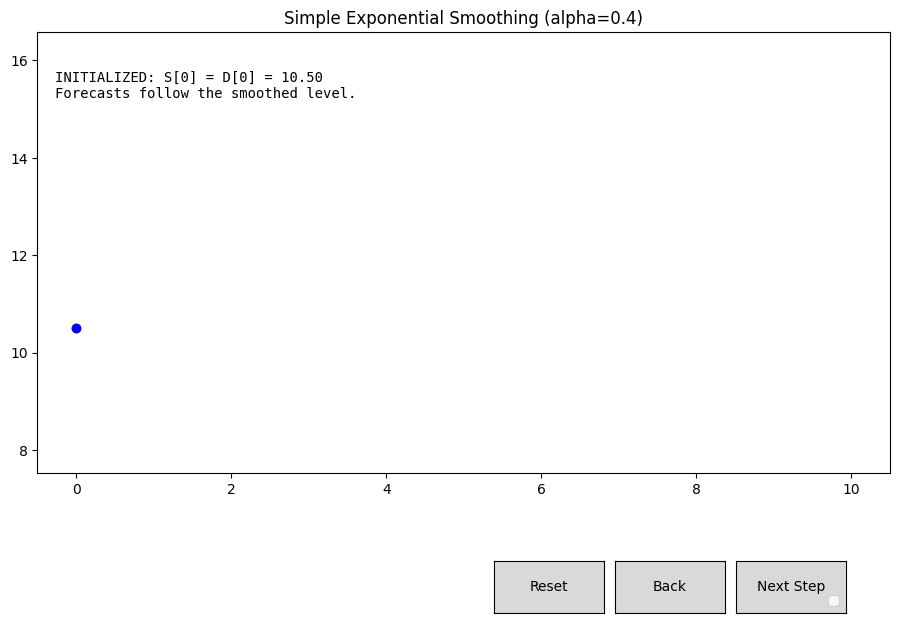

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

# Simple Exponential Smoothing (SES) Demo

np.random.seed(42)
n_points = 10
time = np.arange(n_points)
data = 10 + np.random.normal(0, 1.0, n_points)
alpha = 0.4

levels = np.zeros(n_points)
levels[0] = data[0]
for t in range(1, n_points):
    levels[t] = alpha * data[t] + (1 - alpha) * levels[t - 1]

# Plot
fig, ax = plt.subplots(figsize=(11, 7))
plt.subplots_adjust(bottom=0.25)
ax.set_xlim(-0.5, n_points + 0.5)
ax.set_ylim(min(data) - 2, max(data) + 5)
ax.set_title(f"Simple Exponential Smoothing (alpha={alpha})")

# Connected observation and level series
line_data, = ax.plot(time[:1], data[:1], 'k-', marker='o',
                     label="Observations (D)", alpha=0.6)
line_level, = ax.plot(time[:1], levels[:1], 'b-', marker='o',
                      label="Smoothed Level (S)")

# Forecast-related visuals
line_prev_level, = ax.plot([], [], color='#D3D3D3',
                           linestyle='--', label="Prev Level (Lₜ₋₁)")
line_forecast, = ax.plot([], [], marker='o',
                         label="One-step Forecast (Fₜ₊₁ = Sₜ)")

text_info = ax.text(
    0.02, 0.85,
    f"INITIALIZED: S[0] = D[0] = {levels[0]:.2f}\nForecasts follow the smoothed level.",
    transform=ax.transAxes,
    family='monospace'
)

class SESController:
    """
    Steps per time t (t>=1):
      [1/3] Observation arrives
      [2/3] Previous level as forecast
      [3/3] Update level + extend forecast
    """
    def __init__(self):
        self.t = 1
        self.sub_step = 0
        self.forecast_x = []
        self.forecast_y = []

    def update_plot(self):
        t, s = self.t, self.sub_step

        if t >= n_points:
            return

        if s == 0:  # Forecast for current period
            prev_S = levels[t-1]
            line_prev_level.set_data([t-1, t], [prev_S, prev_S])
            line_forecast.set_data([], [])
            text_info.set_text(
                f"TIME {t} [1/3]: FORECAST\n"
                f"F[{t}] = S[{t-1}] {prev_S:.2f}"
            )

        elif s == 1:  # Observation
            line_data.set_data(time[:t+1], data[:t+1])
            line_level.set_data(time[:t], levels[:t])
            #line_prev_level.set_data([], [])
            text_info.set_text(
                f"TIME {t} [2/3]: NEW OBSERVATION\n"
                f"D[{t}] = {data[t]:.2f} arrives."
            )
        
        elif s == 2:  # Update level + extend forecast path
            line_level.set_data(time[:t+1], levels[:t+1])

            # Append connected forecast
            self.forecast_x.append(t)
            self.forecast_y.append(levels[t])
            #line_forecast.set_data([t-1, t], [levels[t-1], levels[t]])

            text_info.set_text(
                f"TIME {t} [3/3]: UPDATE LEVEL\n"
                f"S[{t}] = {alpha}({data[t]:.2f})-(1-{alpha}){levels[t-1]:.2f} = {levels[t]:.2f}\n"
                f"Smoothed level updated."
            )

        plt.draw()

    def next(self, event):
        self.update_plot()
        self.sub_step += 1
        if self.sub_step > 2:
            self.sub_step = 0
            self.t += 1

    def back(self, event):
        self.sub_step -= 1
        if self.sub_step < 0:
            if self.t > 1:
                self.t -= 1
                self.sub_step = 2
                self.forecast_x = self.forecast_x[:-1]
                self.forecast_y = self.forecast_y[:-1]
            else:
                self.sub_step = 0
        self.update_plot()

    def reset(self, event):
        self.t = 1
        self.sub_step = 0
        self.forecast_x.clear()
        self.forecast_y.clear()
        line_data.set_data(time[:1], data[:1])
        line_level.set_data(time[:1], levels[:1])
        line_prev_level.set_data([], [])
        line_forecast.set_data([], [])
        text_info.set_text("RESET: Back to seed state.")
        plt.draw()

callback = SESController()

btn_reset = Button(plt.axes([0.54, 0.05, 0.1, 0.075]), 'Reset')
btn_back  = Button(plt.axes([0.65, 0.05, 0.1, 0.075]), 'Back')
btn_next  = Button(plt.axes([0.76, 0.05, 0.1, 0.075]), 'Next Step')

btn_reset.on_clicked(callback.reset)
btn_back.on_clicked(callback.back)
btn_next.on_clicked(callback.next)

plt.legend(loc='lower right')
plt.show()


### Double Exponential Smoothing

/var/folders/ht/879gb0f17j9__nx8w63714yw0000gn/T/ipykernel_95502/544137622.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


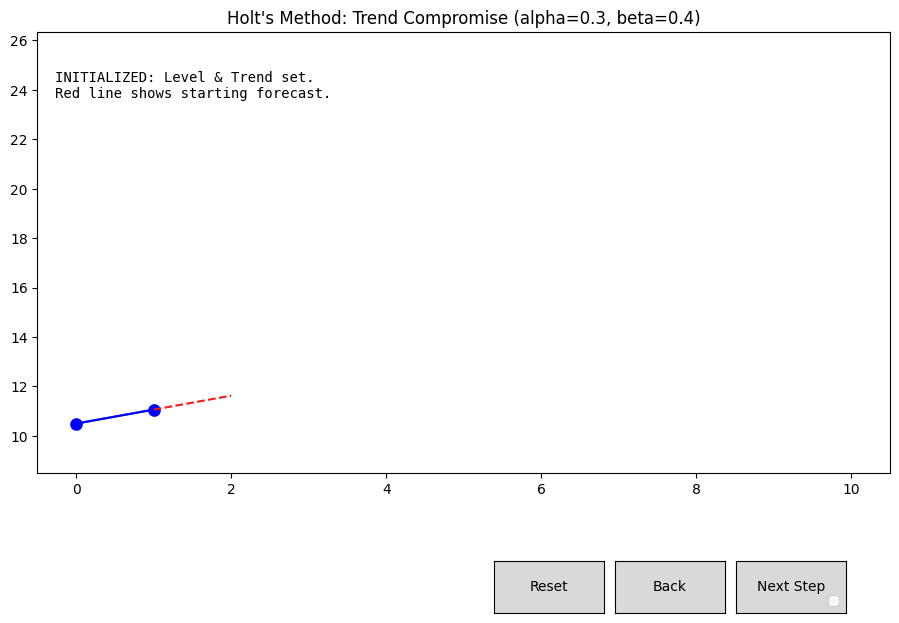

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

np.random.seed(42)
n_points = 10
time = np.arange(n_points)
data = 10 + 1.2 * time + np.random.normal(0, 1.0, n_points)
alpha, beta = 0.3, 0.4

levels = np.zeros(n_points)
trends = np.zeros(n_points)

#start with two points plotted
levels[0], levels[1] = data[0], data[1]
trends[0], trends[1] = data[1]-data[0], data[1]-data[0]

for t in range(2, n_points):
    levels[t] = alpha * data[t] + (1 - alpha) * (levels[t-1] + trends[t-1])
    trends[t] = beta * (levels[t] - levels[t-1]) + (1 - beta) * trends[t-1]

# Plot
fig, ax = plt.subplots(figsize=(11, 7))
plt.subplots_adjust(bottom=0.25)
ax.set_xlim(-0.5, n_points + 0.5)
ax.set_ylim(min(data) - 2, max(data) + 5)
ax.set_title(f"Holt's Method: Trend Compromise (alpha={alpha}, beta={beta})")

# Static seed markers
ax.plot(time[:2], data[:2], 'k-o', alpha=0.1) 
ax.plot(time[:2], levels[:2], 'b-o', markersize=8, alpha=0.3)

# Dynamic plot elements
line_data, = ax.plot(time[:2], data[:2], 'k-o', label="New Observation (y)", alpha=0.4)
line_level, = ax.plot(time[:2], levels[:2], 'b-o', label="New Level (L)", markersize=8)
line_forecast, = ax.plot([1, 2], [levels[1], levels[1] + trends[1]], color="#F71818", linestyle='--', label="New Forecast (b_t)")
line_prev_trend, = ax.plot([], [], color="#0E0D0D", linestyle='--', label="Prev Trend (b_t-1)")
line_local_jump, = ax.plot([], [], color="#1ED12A", linestyle='--', label="Recent Jump (L_t - L_t-1)")

text_info = ax.text(0.02, 0.85, "INITIALIZED: Level & Trend set.\nRed line shows starting forecast.", transform=ax.transAxes, family='monospace')

class HoltController:
    def __init__(self):
        self.t = 2 
        self.sub_step = 0 

    def update_plot(self):
        t, s = self.t, self.sub_step
        
        if s == 0: # Observation
            line_data.set_data(time[:t+1], data[:t+1])
            line_level.set_data(time[:t], levels[:t])
            line_prev_trend.set_data([], [])
            line_local_jump.set_data([], [])
            text_info.set_text(f"TIME {t} [1/3]: NEW OBSERVATION\ny[{t}] appears. No updates yet.")
        
        elif s == 1: # Level
            line_level.set_data(time[:t+1], levels[:t+1])
            text_info.set_text(f"TIME {t} [2/3]: UPDATE LEVEL\nS[{t}] adjusted. Smoothed level sits between forecast and new observation.")
            
        elif s == 2: # Trend Compromise
            if t < n_points - 1:
                # Previous Trend (Black)
                line_prev_trend.set_data([t, t+1], [levels[t], levels[t] + trends[t-1]])
                # Latest Trend (Green)
                line_local_jump.set_data([t, t+1], [levels[t], levels[t] + (levels[t] - levels[t-1])])
                # New Forecast (Red)
                line_forecast.set_data([t, t+1], [levels[t], levels[t] + trends[t]])
                
            text_info.set_text(f"TIME {t} [3/3]: TREND COMPROMISE\nRed = {beta}*Green + {1-beta}*Black\nG[{t}] sits between previous smoothed slope and slope between two most recent smoothed levels.")
        
        plt.draw()

    def next(self, event):
        if self.t < n_points:
            self.update_plot()
            self.sub_step += 1
            if self.sub_step > 2:
                self.sub_step = 0
                self.t += 1

    def back(self, event):
        self.sub_step -= 1
        if self.sub_step < 0:
            if self.t > 2:
                self.t -= 1
                self.sub_step = 2
            else: self.sub_step = 0
        self.update_plot()

    def reset(self, event):
        self.t = 2
        self.sub_step = 0
        line_data.set_data(time[:2], data[:2])
        line_level.set_data(time[:2], levels[:2])
        line_forecast.set_data([1, 2], [levels[1], levels[1] + trends[1]])
        line_prev_trend.set_data([], [])
        line_local_jump.set_data([], [])
        text_info.set_text("RESET: Back to seed state.")
        plt.draw()

callback = HoltController()
btn_reset = Button(plt.axes([0.54, 0.05, 0.1, 0.075]), 'Reset')
btn_back = Button(plt.axes([0.65, 0.05, 0.1, 0.075]), 'Back')
btn_next = Button(plt.axes([0.76, 0.05, 0.1, 0.075]), 'Next Step')
btn_reset.on_clicked(callback.reset)
btn_back.on_clicked(callback.back)
btn_next.on_clicked(callback.next)

plt.legend(loc='lower right')
plt.show()



/var/folders/ht/879gb0f17j9__nx8w63714yw0000gn/T/ipykernel_93834/544137622.py:110: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


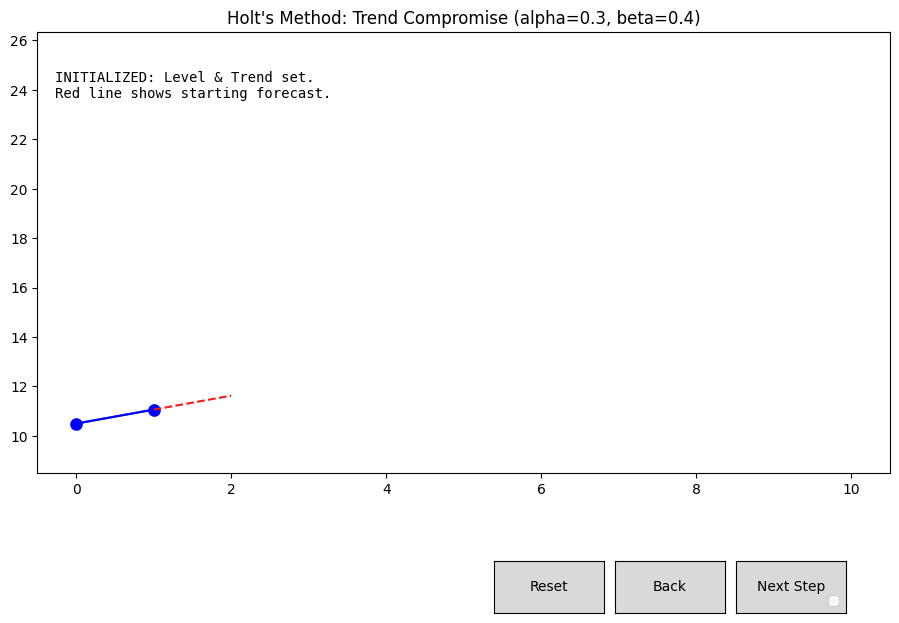

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

np.random.seed(42)
n_points = 10
time = np.arange(n_points)
data = 10 + 1.2 * time + np.random.normal(0, 1.0, n_points)
alpha, beta = 0.3, 0.4

levels = np.zeros(n_points)
trends = np.zeros(n_points)

#start with two points plotted
levels[0], levels[1] = data[0], data[1]
trends[0], trends[1] = data[1]-data[0], data[1]-data[0]

for t in range(2, n_points):
    levels[t] = alpha * data[t] + (1 - alpha) * (levels[t-1] + trends[t-1])
    trends[t] = beta * (levels[t] - levels[t-1]) + (1 - beta) * trends[t-1]

# Plot
fig, ax = plt.subplots(figsize=(11, 7))
plt.subplots_adjust(bottom=0.25)
ax.set_xlim(-0.5, n_points + 0.5)
ax.set_ylim(min(data) - 2, max(data) + 5)
ax.set_title(f"Holt's Method: Trend Compromise (alpha={alpha}, beta={beta})")

# Static seed markers
ax.plot(time[:2], data[:2], 'k-o', alpha=0.1) 
ax.plot(time[:2], levels[:2], 'b-o', markersize=8, alpha=0.3)

# Dynamic plot elements
line_data, = ax.plot(time[:2], data[:2], 'k-o', label="New Observation (y)", alpha=0.4)
line_level, = ax.plot(time[:2], levels[:2], 'b-o', label="New Level (L)", markersize=8)
line_forecast, = ax.plot([1, 2], [levels[1], levels[1] + trends[1]], color="#F71818", linestyle='--', label="New Forecast (b_t)")
line_prev_trend, = ax.plot([], [], color="#0E0D0D", linestyle='--', label="Prev Trend (b_t-1)")
line_local_jump, = ax.plot([], [], color="#1ED12A", linestyle='--', label="Recent Jump (L_t - L_t-1)")

text_info = ax.text(0.02, 0.85, "INITIALIZED: Level & Trend set.\nRed line shows starting forecast.", transform=ax.transAxes, family='monospace')

class HoltController:
    def __init__(self):
        self.t = 2 
        self.sub_step = 0 

    def update_plot(self):
        t, s = self.t, self.sub_step
        
        if s == 0: # Observation
            line_data.set_data(time[:t+1], data[:t+1])
            line_level.set_data(time[:t], levels[:t])
            line_prev_trend.set_data([], [])
            line_local_jump.set_data([], [])
            text_info.set_text(f"TIME {t} [1/3]: NEW OBSERVATION\ny[{t}] appears. No updates yet.")
        
        elif s == 1: # Level
            line_level.set_data(time[:t+1], levels[:t+1])
            text_info.set_text(f"TIME {t} [2/3]: UPDATE LEVEL\nS[{t}] adjusted. Smoothed level sits between forecast and new observation.")
            
        elif s == 2: # Trend Compromise
            if t < n_points - 1:
                # Previous Trend (Black)
                line_prev_trend.set_data([t, t+1], [levels[t], levels[t] + trends[t-1]])
                # Latest Trend (Green)
                line_local_jump.set_data([t, t+1], [levels[t], levels[t] + (levels[t] - levels[t-1])])
                # New Forecast (Red)
                line_forecast.set_data([t, t+1], [levels[t], levels[t] + trends[t]])
                
            text_info.set_text(f"TIME {t} [3/3]: TREND COMPROMISE\nRed = {beta}*Green + {1-beta}*Black\nG[{t}] sits between previous smoothed slope and slope between two most recent smoothed levels.")
        
        plt.draw()

    def next(self, event):
        if self.t < n_points:
            self.update_plot()
            self.sub_step += 1
            if self.sub_step > 2:
                self.sub_step = 0
                self.t += 1

    def back(self, event):
        self.sub_step -= 1
        if self.sub_step < 0:
            if self.t > 2:
                self.t -= 1
                self.sub_step = 2
            else: self.sub_step = 0
        self.update_plot()

    def reset(self, event):
        self.t = 2
        self.sub_step = 0
        line_data.set_data(time[:2], data[:2])
        line_level.set_data(time[:2], levels[:2])
        line_forecast.set_data([1, 2], [levels[1], levels[1] + trends[1]])
        line_prev_trend.set_data([], [])
        line_local_jump.set_data([], [])
        text_info.set_text("RESET: Back to seed state.")
        plt.draw()

callback = HoltController()
btn_reset = Button(plt.axes([0.54, 0.05, 0.1, 0.075]), 'Reset')
btn_back = Button(plt.axes([0.65, 0.05, 0.1, 0.075]), 'Back')
btn_next = Button(plt.axes([0.76, 0.05, 0.1, 0.075]), 'Next Step')
btn_reset.on_clicked(callback.reset)
btn_back.on_clicked(callback.back)
btn_next.on_clicked(callback.next)

plt.legend(loc='lower right')
plt.show()